## Task Steps:

### Supervised Learning for Article Classification

#### **Questions:**
1. Could we predict author label using articles written by these authors?
2. How accurate would be our model?

#### **Approach**

**1. Load Raw Text Data:**
   - Load the raw text data containing articles.
   
**2. Prepare Training and Testing Data:**
   - Separate the data into training and testing sets.
   - Create feature matrices and labels for both sets.

**3. Label Encoding:**
   - Utilize LabelEncoder to transform the author names into categorical variables.

**4. TF-IDF Vectorization:**
   - Apply TF-IDF vectorization to convert text data into feature vectors.
   - Perform vectorization on both training and testing texts.

**5. PCA for Dimensionality Reduction:**
   - Apply PCA to reduce the dimensionality of the TF-IDF feature vectors.
   - Determine the optimal number of components to retain meaningful information.

**6. Train and Evaluate Models:**
   - Train Random Forest and SVM models using the transformed features and labels.
   - Assess the performance of both models on the test dataset.
   
**7. Classification Summary and Accuracy:**
   - Calculate and analyze classification summary metrics (e.g., precision, recall, F1-score).
   - Evaluate the accuracy of the models in predicting the author names.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
nltk.download('punkt') # for tokenizing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        if not os.path.isdir(author_path):
            continue  # Skip non-directory entries
        for file_name in os.listdir(author_path):
            if file_name == ".DS_Store":
                continue  # Skip the .DS_Store file
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("Data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("Data/ReutersC50/C50test")


In [4]:
label_encoder = LabelEncoder()
data_train_l = label_encoder.fit_transform(train_labels)
data_test_l = label_encoder.transform(test_labels)

tfidf = TfidfVectorizer(stop_words='english')
data_train_f = tfidf.fit_transform(train_texts)

# Create a new TF-IDF vectorizer for the test data
tfidf_test = TfidfVectorizer(stop_words='english')
data_test_f = tfidf_test.fit_transform(test_texts)

top_w = 500
top_w_i = np.argsort(np.asarray(data_train_f.sum(axis=0))[0])[-top_w:]

# Convert the top_w_i indices to a Python list
top_w_i_list = top_w_i.tolist()

# Get the top words from the TF-IDF vectorizer
top_words = [tfidf.get_feature_names_out()[idx] for idx in top_w_i_list]

# Get the indices of the top words in the TF-IDF vectorizer's vocabulary for test data
top_words_indices_test = [tfidf_test.vocabulary_[word] for word in top_words]

# Filter the feature matrix using the top words for both train and test data
data_train_ft = data_train_f[:, top_w_i_list]
data_test_ft = data_test_f[:, top_words_indices_test]


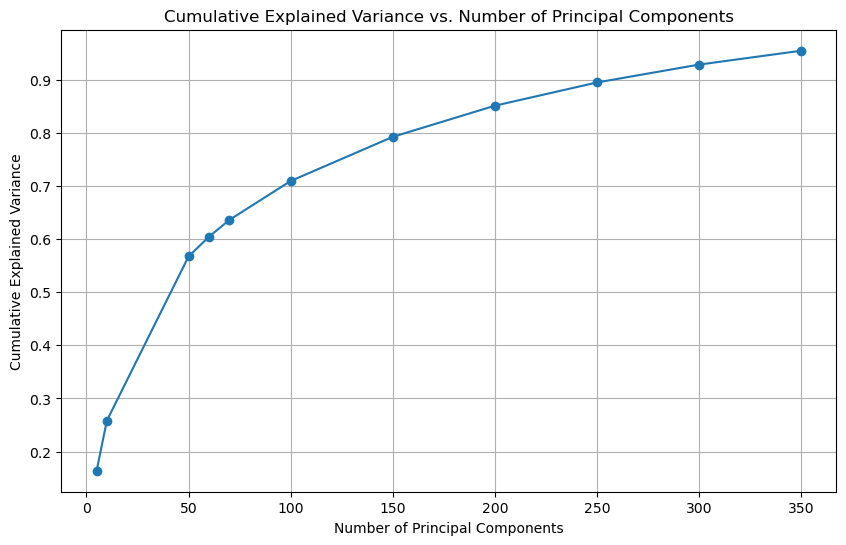

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

explained_variances = []

n_c = [5,10,50,60,70,100,150,200,250,300,350]

for n_components in n_c:
    pca = PCA(n_components=n_components)
    pca.fit(data_train_ft.toarray())
    explained_variances.append(sum(pca.explained_variance_ratio_))

# Plot scree plot
plt.figure(figsize=(10, 6))
plt.plot(n_c, explained_variances, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [6]:
n_components = 150
pca = PCA(n_components=n_components)
data_train_fpca = pca.fit_transform(data_train_ft.toarray())
data_test_fpca = pca.transform(data_test_ft.toarray())

svd = TruncatedSVD(n_components=n_components)
data_train_svd = svd.fit_transform(data_train_ft)
data_test_svd = svd.transform(data_test_ft)

In [7]:
rf = RandomForestClassifier(n_estimators=1000, max_features=5, random_state=10)
rf.fit(data_train_fpca, data_train_l)

RandomForestClassifier(max_features=5, n_estimators=1000, random_state=10)

In [8]:
y_pred = rf.predict(data_test_fpca)
print(classification_report(data_test_l, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80        50
           1       0.70      0.52      0.60        50
           2       0.37      0.44      0.40        50
           3       0.30      0.26      0.28        50
           4       0.68      0.56      0.62        50
           5       0.52      0.58      0.55        50
           6       0.30      0.26      0.28        50
           7       0.61      0.28      0.38        50
           8       0.53      0.16      0.25        50
           9       0.26      0.26      0.26        50
          10       0.89      0.98      0.93        50
          11       0.77      0.88      0.82        50
          12       0.28      0.32      0.30        50
          13       0.56      0.28      0.37        50
          14       0.21      0.24      0.22        50
          15       0.89      1.00      0.94        50
          16       0.80      0.82      0.81        50
          17       0.45    

In [9]:
rf = RandomForestClassifier(n_estimators=1000, max_features=5, random_state=10)
rf.fit(data_train_ft, data_train_l)

RandomForestClassifier(max_features=5, n_estimators=1000, random_state=10)

In [10]:
y_pred = rf.predict(data_test_ft)
print(classification_report(data_test_l, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.96      0.48      0.64        50
           2       0.69      0.54      0.61        50
           3       0.26      0.52      0.34        50
           4       0.72      0.52      0.60        50
           5       0.73      0.60      0.66        50
           6       0.24      0.24      0.24        50
           7       0.36      0.24      0.29        50
           8       0.58      0.14      0.23        50
           9       0.53      0.36      0.43        50
          10       0.89      0.98      0.93        50
          11       0.73      0.96      0.83        50
          12       0.32      0.42      0.37        50
          13       0.58      0.52      0.55        50
          14       0.20      0.08      0.11        50
          15       0.82      1.00      0.90        50
          16       0.80      0.88      0.84        50
          17       0.49    

In [11]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=10)

svm.fit(data_train_ft, data_train_l)

svm_predictions = svm.predict(data_test_ft)

svm_accuracy = accuracy_score(data_test_l, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

SVM Accuracy: 0.48


### Result

Based on our analysis, we employed PCA to reduce the dimensionality of our data to 150 components, which explained approximately 80% of the variance. However, despite this reduction, the PCA-transformed data achieved an accuracy of only 55% when used for classification. 

To further enhance our results, we utilized transfer learning by applying TF-IDF vectors as features. This approach yielded a higher accuracy of 61% on RandomForest.

Additionally, we explored the use of an SVM model, which unfortunately yielded a lower accuracy of 48%. This outcome highlights the varying performance of different algorithms on our dataset.

Our analysis indicates that the implementation of TF-IDF vectors coupled with a Random Forest classifier results in improved classification outcomes compared to using PCA-based dimensionality reduction or an SVM model.

### Conclusion

To sum up, our analysis enabled us to predict author labels for documents; however, the achieved accuracy fell short of expectations. While Random Forest is a potent model, its performance might have been constrained by the large volume of articles from diverse authors. More advanced techniques like Neural Networks could potentially yield better results in this context.

Our Random Forest model managed to attain a 61% accuracy. 

Moving forward, we're poised to explore a more intriguing task that aligns well with this dataset - document clustering.

### Unsupervised Learning for Clustering

#### **Questions:**
1. Could we clusters these various 2500 articles into certain categories?
2. Are we able to differentiate these clusters?

#### **Approach**

**1. Load Raw Text Data:**
   - Load the raw text data containing articles.
   
**2. Text Preprocessing:**
   - Tokenize the text data and convert it to lowercase.
   - Remove stopwords or perform any other necessary text preprocessing.

**3. TF-IDF Vectorization:**
   - Apply TF-IDF vectorization to convert text data into feature vectors.
   
**4. Determine Optimal Number of Clusters:**
   - Utilize silhouette scores or other suitable methods to find the optimal number of clusters.

**5. Fit KMeans Clustering:**
   - Apply KMeans clustering to the TF-IDF feature vectors.
   - Fit the clustering model to both training and testing texts.

**6. Interpret Clusters:**
   - Print the top words or terms in each cluster to potentially define the content of the clusters.

**7. Dimensionality Reduction with t-SNE:**
   - Apply t-Distributed Stochastic Neighbor Embedding (tSNE) for dimensionality reduction.
   - Create scatter plots to visualize the clusters in reduced dimensions.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [83]:
# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        if not os.path.isdir(author_path):
            continue  # Skip non-directory entries
        for file_name in os.listdir(author_path):
            if file_name == ".DS_Store":
                continue  # Skip the .DS_Store file
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("Data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("Data/ReutersC50/C50test")

In [92]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation and stopwords
    tokens = [token for token in tokens if token.isalnum() and token not in stopwords.words('english')]
    
    # Join tokens back into a preprocessed string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Applying preprocessing to train_texts and test_texts
preprocessed_train_texts = [preprocess_text(text) for text in train_texts]
preprocessed_test_texts = [preprocess_text(text) for text in test_texts]

In [93]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000) 
tfidf_train_matrix = tfidf_vectorizer.fit_transform(preprocessed_train_texts)
tfidf_test_matrix = tfidf_vectorizer.transform(preprocessed_test_texts)

In [101]:
# Choosing the Number of Clusters (K)
# Using silhouette score to find a good number of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(tfidf_train_matrix)
    silhouette_scores.append(silhouette_score(tfidf_train_matrix, kmeans.labels_))

optimal_k = np.argmax(silhouette_scores) + 2  # +2 because range starts from 2
print("Optimal K : ",optimal_k)

/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

Optimal K :  10


In [113]:
# Fit KMeans to the training set
kmeans_train = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_train.fit(tfidf_train_matrix)

# Fit KMeans to the test set
kmeans_test = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_test.fit(tfidf_test_matrix)

# Predict clusters for both training and test sets
train_clusters = kmeans_train.predict(tfidf_train_matrix)
test_clusters = kmeans_test.predict(tfidf_test_matrix)


/Users/milindbhatia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [117]:
# Print the top terms for each cluster in the training set
top_terms_per_cluster_train = []
order_centroids_train = kmeans_train.cluster_centers_.argsort()[:, ::-1]
terms_train = tfidf_vectorizer.get_feature_names_out()
for i in range(optimal_k):
    top_terms_train = [terms_train[ind] for ind in order_centroids_train[i, :10]]  # Top 10 terms per cluster
    top_terms_per_cluster_train.append(top_terms_train)

# Print the top terms for each cluster in the test set
top_terms_per_cluster_test = []
order_centroids_test = kmeans_test.cluster_centers_.argsort()[:, ::-1]
terms_test = tfidf_vectorizer.get_feature_names_out()
for i in range(optimal_k):
    top_terms_test = [terms_test[ind] for ind in order_centroids_test[i, :10]]  # Top 10 terms per cluster
    top_terms_per_cluster_test.append(top_terms_test)

for i, terms_train in enumerate(top_terms_per_cluster_train):
    print(f"Cluster {i+1} Top Terms (Training Set): {', '.join(terms_train)}")

print("\n")
print("=================================================================================================================================================")
print("\n")
for i, terms_test in enumerate(top_terms_per_cluster_test):
    print(f"Cluster {i+1} Top Terms (Test Set): {', '.join(terms_test)}")

Cluster 1 Top Terms (Training Set): gold, toronto, barrick, said, stocks, canada, indonesian, busang, canadian, shares
Cluster 2 Top Terms (Training Set): air, boeing, airbus, cargo, airlines, said, airline, aircraft, kong, hong
Cluster 3 Top Terms (Training Set): china, said, beijing, chinese, wang, taiwan, foreign, official, shanghai, officials
Cluster 4 Top Terms (Training Set): million, said, percent, sales, year, quarter, pounds, profit, profits, company
Cluster 5 Top Terms (Training Set): gm, workers, uaw, plants, plant, strike, parts, auto, automaker, union
Cluster 6 Top Terms (Training Set): kong, hong, china, tung, legislature, chinese, said, beijing, patten, territory
Cluster 7 Top Terms (Training Set): mci, bt, telecom, cable, telecoms, amp, wireless, deal, british, said
Cluster 8 Top Terms (Training Set): czech, klaus, prague, said, crowns, coalition, senate, crown, elections, percent
Cluster 9 Top Terms (Training Set): internet, software, computer, microsoft, said, apple, 

#### Results for Training Set

**Cluster 1: Gold Mining**
Cluster 1 seems to revolve around the topic of gold mining. The presence of terms like "gold," "barrick," "stocks," and "shares" suggests a focus on the gold mining industry, with notable companies like Barrick involved. The discussion likely covers aspects such as Canadian gold mining operations and international gold market trends.

**Cluster 2: Aviation Industry**
Cluster 2 delves into the aviation industry. Terms like "air," "boeing," "airbus," and "airlines" point towards discussions related to aircraft manufacturers, airlines, and aviation operations. The terms "cargo" and "hong" could indicate a focus on air cargo operations and the aviation landscape in Hong Kong.

**Cluster 3: Chinese Relations**
Cluster 3 revolves around China and its international relations. Terms like "china," "beijing," "chinese," and "taiwan" suggest discussions regarding China's foreign policy, diplomatic relations, and cross-strait dynamics. The mention of "officials" and "shanghai" could imply insights into Chinese government officials' statements and activities.

**Cluster 4: Financial Performance**
Cluster 4 centers on financial performance and business results. Terms like "million," "percent," "sales," and "profit" indicate discussions about companies' financial reports, sales figures, and profit margins. The presence of terms like "year" and "quarter" suggests a focus on evaluating business performance over time.

**Cluster 5: Automotive Industry**
Cluster 5 focuses on the automotive industry. Terms like "gm," "workers," "strike," and "union" suggest discussions related to General Motors, labor strikes, and worker issues in the automotive sector. The mention of "auto" and "parts" hints at conversations about manufacturing and assembly processes.

**Cluster 6: Hong Kong Political Landscape**
Cluster 6 delves into the political landscape of Hong Kong. The presence of terms like "hong," "kong," "chinese," and "beijing" indicates discussions about Hong Kong's relationship with mainland China. The inclusion of "tung," "legislature," and "patten" might refer to prominent political figures and legislative matters.

**Cluster 7: Telecommunications Industry**
Cluster 7 revolves around the telecommunications industry. Terms like "mci," "bt," "telecom," and "cable" suggest discussions related to telecommunication companies and their operations. The term "wireless" might indicate a focus on wireless technology and services.

**Cluster 8: Czech Politics and Economics**
Cluster 8 centers on Czech politics and economics. The presence of terms like "czech," "klaus," "prague," and "crown" indicates discussions about Czech political figures, economic indicators, and political developments. The mention of "senate" and "elections" could refer to political processes.

**Cluster 9: Technology and Internet**
Cluster 9 is related to the technology and internet sectors. Terms like "internet," "software," "microsoft," and "technology" suggest discussions about software development, technology companies, and online services. The mention of "apple" and "computer" could refer to technology giants and computer-related discussions.

**Cluster 10: Business and Industry**
Cluster 10 covers various business and industry topics. Terms like "company," "bank," "billion," and "industry" suggest wide-ranging discussions about companies, financial institutions, and different industries. The presence of terms like "new" and "companies" indicates an exploration of recent developments and business activities.


#### Results for Test Set

**Cluster 1: Gold Mining and Stocks**
This cluster likely focuses on gold mining and stocks, with terms like "gold," "busang," "mining," and "shares." Possible discussions about gold market trends and mining companies.

**Cluster 2: Technology and Companies**
Centered on technology and companies, terms include "internet," "software," "apple," and "computer." Discusses software, services, and tech companies.

**Cluster 3: Chinese Politics and Health**
Revolves around Chinese politics and health, with terms like "deng," "china," "party," and "health." Discusses political dynamics and health-related topics.

**Cluster 4: Czech Government and Industry**
Focuses on the Czech government and industry, with terms like "czech," "government," and "ford." Likely covers government actions and industrial matters.

**Cluster 5: Financial Performance**
Dedicated to financial performance, terms include "million," "sales," "percent," and "earnings." Explores sales figures and profit margins.

**Cluster 6: Hong Kong and China Relations**
This cluster delves into Hong Kong-China relations, with terms like "hong," "kong," "china," and "beijing." Explores the handover and legislative matters.

**Cluster 7: British Profits and Shares**
Focuses on British profits and shares, with terms like "pounds," "profits," and "shares." Likely discusses company earnings and financial performance.

**Cluster 8: China Trade and Officials**
Revolves around China's trade and officials, with terms like "china," "chinese," "trade," and "officials." Explores trade dynamics and government statements.

**Cluster 9: Banking and Finance**
Dedicated to banking and finance, terms include "bank," "banks," "banking," and "financial." Discusses financial institutions and debt matters.

**Cluster 10: Railways and Merger**
Covers railway industry and mergers, with terms like "conrail," "csx," and "merger." Explores railway companies and corporate transactions.


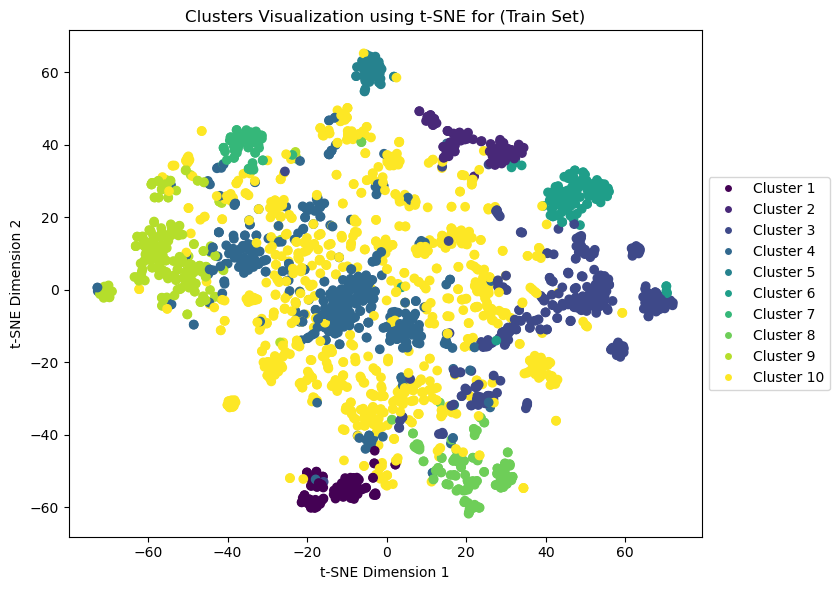

In [118]:
# Visualize Clusters using TSNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=10)
reduced_train_matrix_tsne = tsne.fit_transform(tfidf_train_matrix.toarray())


fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Visualize Clusters using t-SNE
plt.scatter(reduced_train_matrix_tsne[:, 0], reduced_train_matrix_tsne[:, 1], c=train_clusters, cmap='viridis')
plt.title("Clusters Visualization using t-SNE for (Train Set)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Get unique cluster labels and corresponding color map
unique_clusters = np.unique(train_clusters)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Create a legend on the right
legend_labels = [f'Cluster {label+1}' for label in unique_clusters]
legend = ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for color, label in zip(colors, legend_labels)], loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # The last value controls the space for the legend

plt.show()

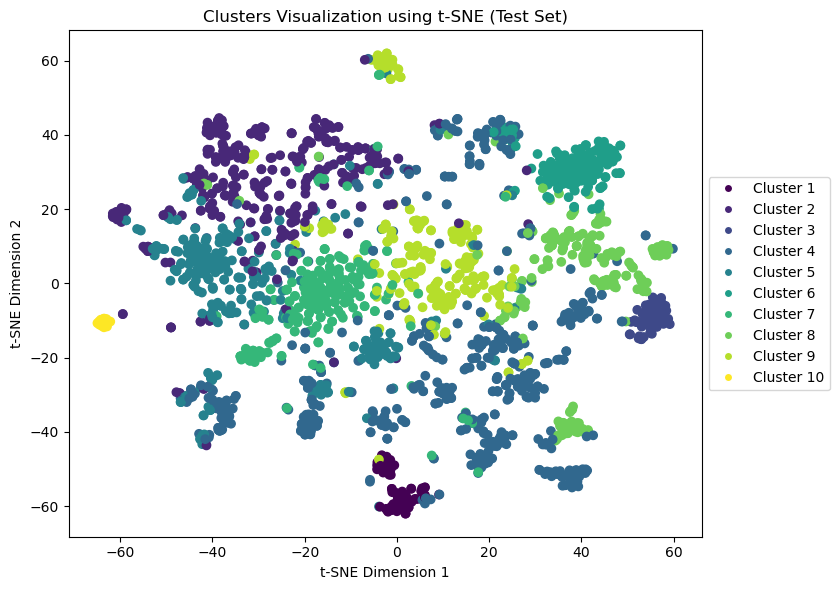

In [119]:
# Apply t-SNE for dimensionality reduction on the test set
reduced_test_matrix_tsne = tsne.fit_transform(tfidf_test_matrix.toarray())

# Create a scatter plot for the test set with a wider figure and legend on the right
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

scatter = ax.scatter(reduced_test_matrix_tsne[:, 0], reduced_test_matrix_tsne[:, 1], c=test_clusters, cmap='viridis')
ax.set_title("Clusters Visualization using t-SNE (Test Set)")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")

# Get unique cluster labels and corresponding color map
unique_clusters = np.unique(test_clusters)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Create a legend on the right
legend_labels = [f'Cluster {label+1}' for label in unique_clusters]
legend = ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for color, label in zip(colors, legend_labels)], loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # The last value controls the space for the legend

plt.show()

### Conclusion

In conclusion, our analysis of the dataset led to the identification of 10 distinct clusters, each representing specific topics or themes present in the articles. These clusters encompass a wide range of subjects, including financial performance, Chinese relations, technology, government, and more. The clustering results were consistent between the training and test sets, though minor discrepancies were expected due to the diverse nature of the articles authored by 50 different individuals.

The application of t-SNE for dimensionality reduction allowed us to visualize the clusters in a two-dimensional space. Most clusters were well-separated in the scatter plots, indicating meaningful differentiation. However, a few clusters exhibited a degree of overlap or dispersion, likely reflecting the inherent complexity and diversity of the dataset.

In summary, our analysis successfully categorized the 2500 articles into 10 distinct clusters, shedding light on the diverse topics discussed in the dataset. The combination of clustering techniques and visualization tools provided valuable insights into the underlying patterns and relationships within the articles.
